In [1]:
import numpy as np
from numpy import cos, sin, pi, absolute, arange, sqrt
import scipy.signal as signal
import scipy.io
from scipy.io.wavfile import write
from scipy.ndimage.interpolation import shift
from utils import *

In [2]:
class Signal:
    def __init__(self,name,data,fd):
        self.name = name
        self.data = data
        self.fd = fd
        self.n = len(data)

    def plot(self,n=None,time=True,frequency=True):
        if n is None:
            n = self.n
        plot_signal(self.data[:n],self.fd,0,f"{self.name}")

In [3]:
inputs = {}
fd = 8000
datapack = scipy.io.loadmat('lab3_signalai.mat')
signal_names = ['variklioSig','kabinosSig','pilotoSig']
for s in signal_names:
    inputs[s] = Signal(s,datapack[s][0],fd)

In [4]:
inputs

def plot_multiple_signals(x,fd,start_delay,title,count,titles,domains=["time","freq"],filename=None):
    # plotting a signal in time and freq domains
    fig, axs = plt.subplots(count,len(domains),figsize=(4*count,8),dpi=100,constrained_layout=True)
    for i in range(count):
        f, s = convert_to_frequency_domain(x[i],fd)
        if "time" in domains:
            if len(domains) > 1:
                plot_amplitude(x[i],fd,start_delay,axs[i][0],sub_title=titles[i])
            else:
                plot_amplitude(x[i],fd,start_delay,axs[i],sub_title=titles[i])
        if "freq" in domains:
            if len(domains) > 1:
                plot_frequency(f,s,fd,axs[i][1],sub_title=titles[i])
            else:
                plot_frequency(f,s,fd,axs[i],sub_title=titles[i])
    fig.suptitle(title)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)


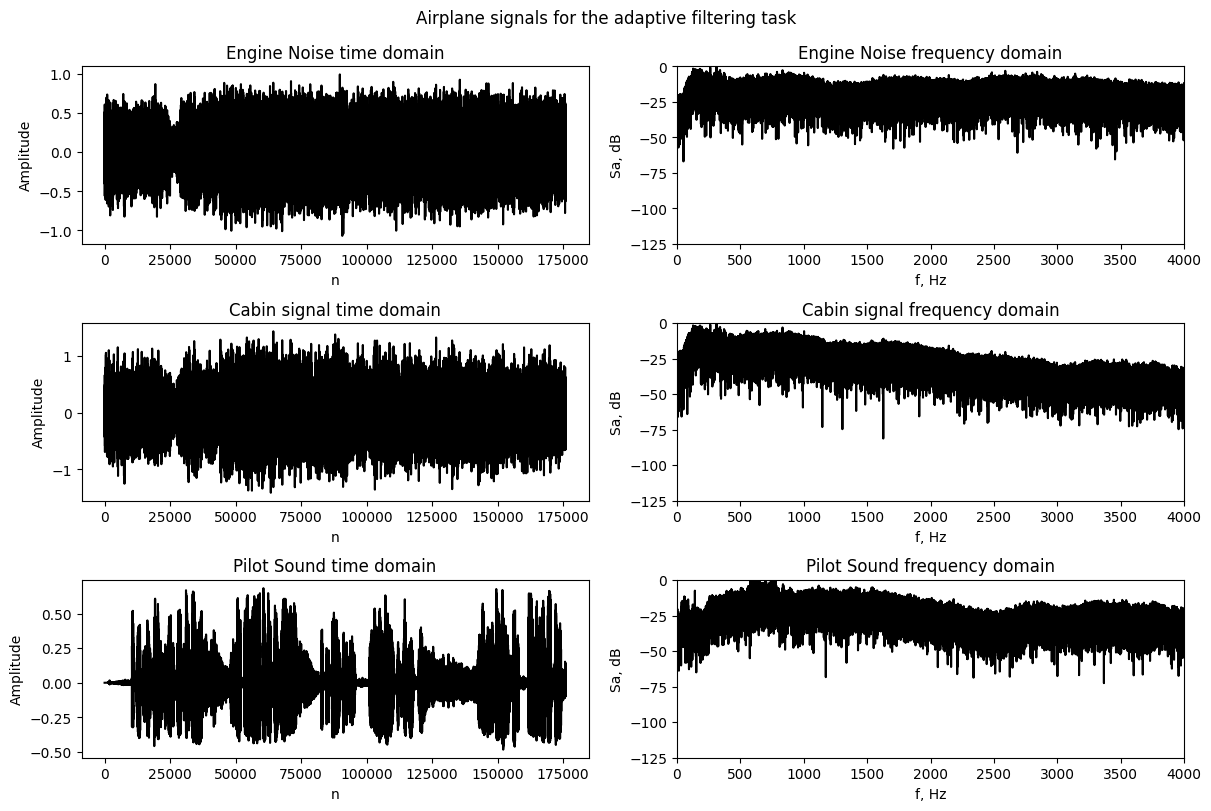

In [5]:
x = [inputs['variklioSig'].data,inputs['kabinosSig'].data,inputs['pilotoSig'].data]
fd = 8000
title = "Airplane signals for the adaptive filtering task"
titles = ["Engine Noise","Cabin signal", "Pilot Sound"]
count = len(x)
plot_multiple_signals(x,fd,0,title,count,titles,domains=["time","freq"],filename='f1.png')

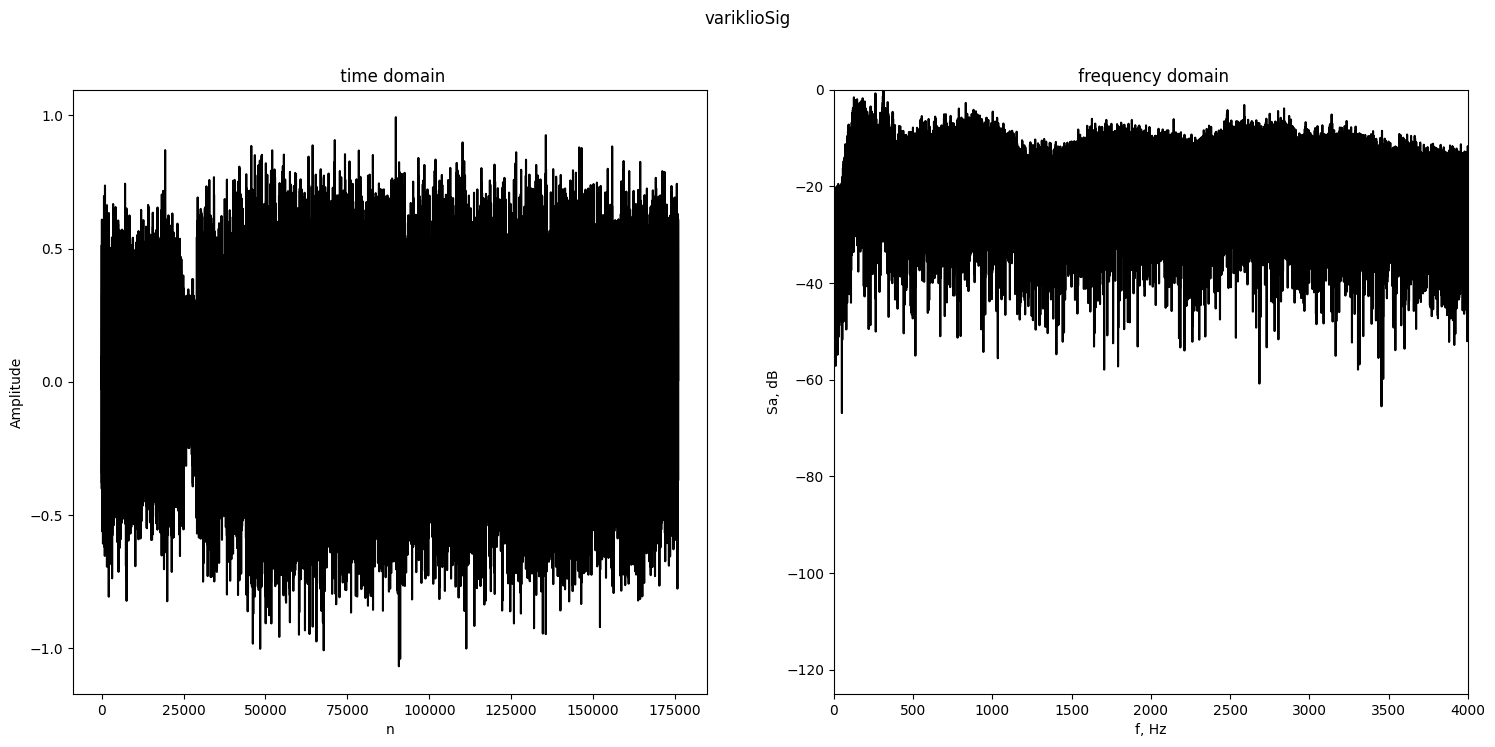

In [6]:
inputs['variklioSig'].plot()


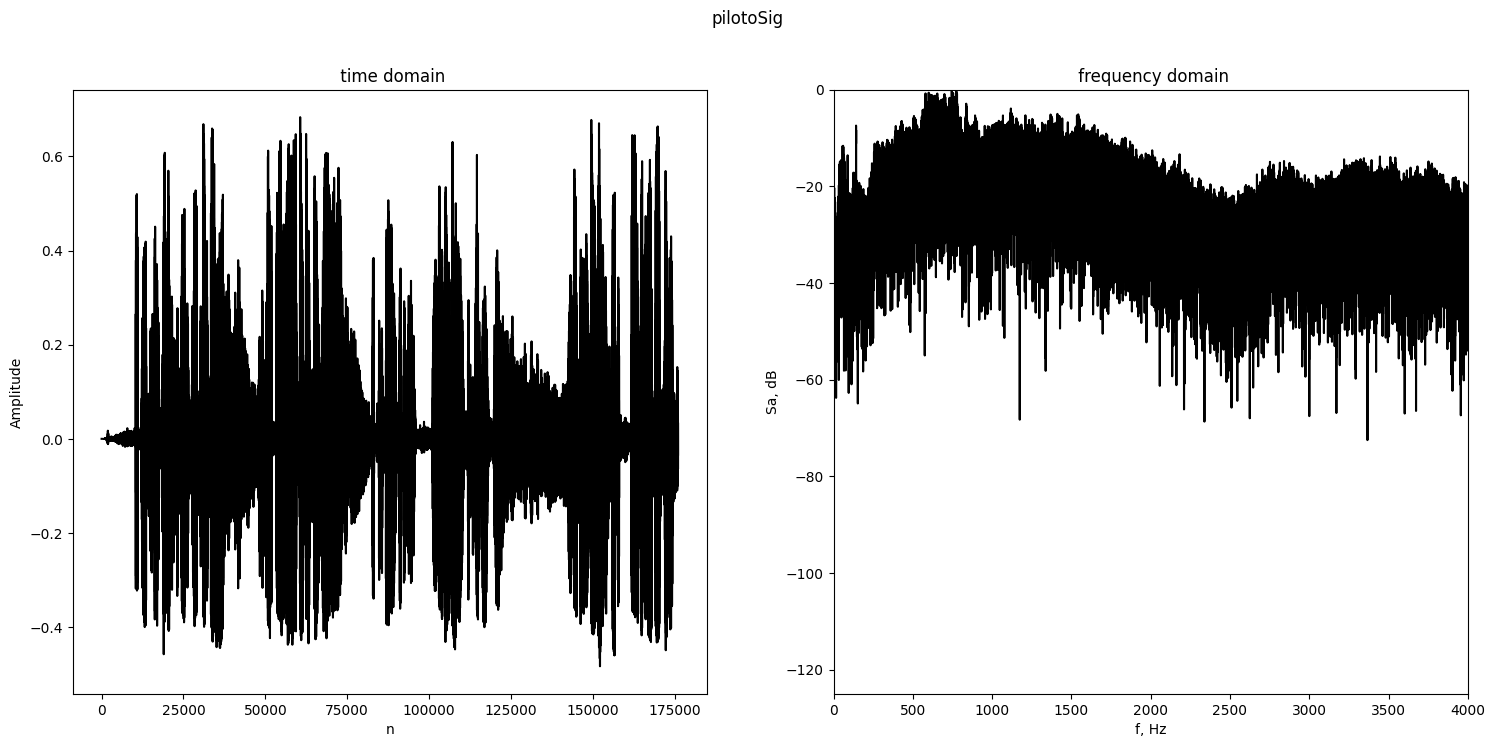

In [7]:
inputs['pilotoSig'].plot()

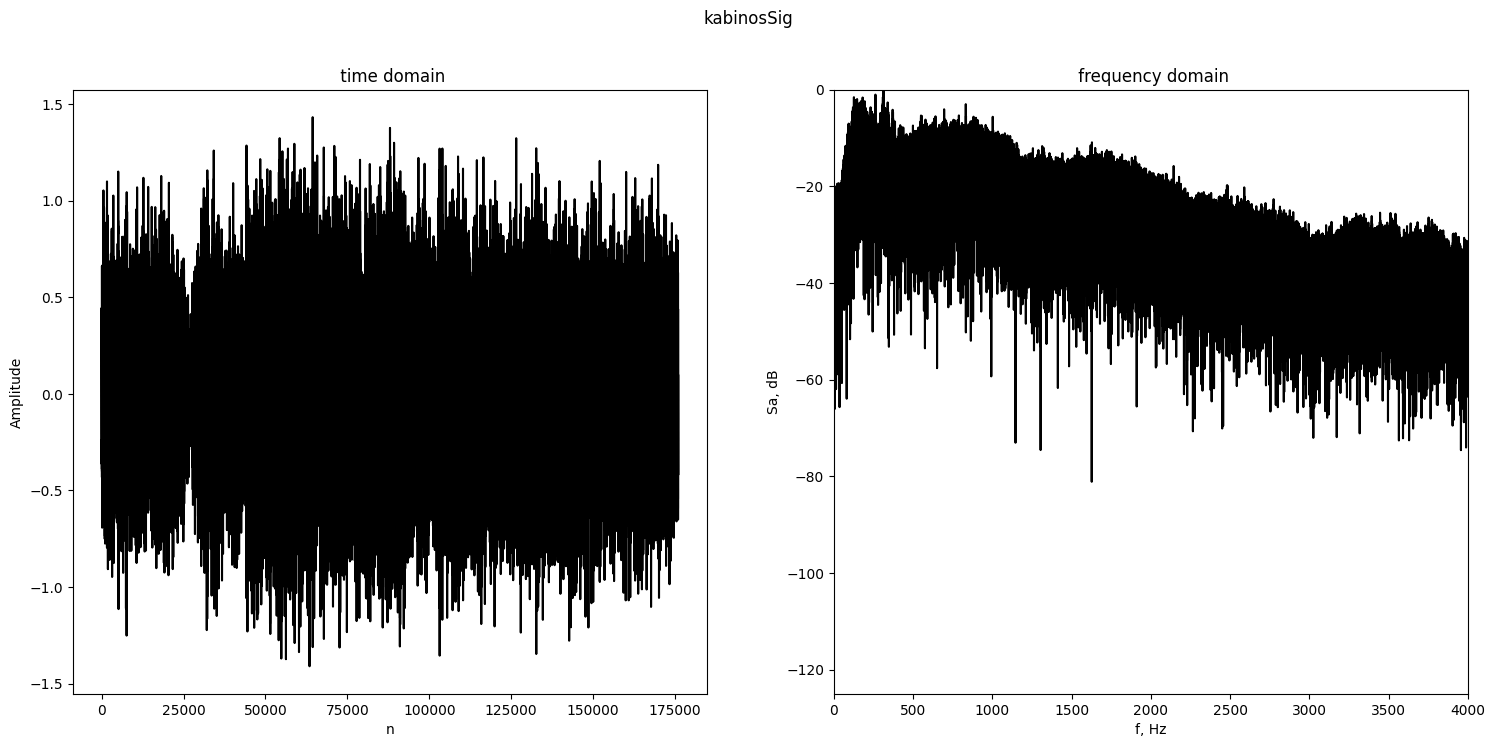

In [8]:
inputs['kabinosSig'].plot()

In [9]:
def mse(x,y):
    return ((x - y)**2).mean(axis=0)

class Filter:
    def __init__(self,name):
        self.name = name

class AdaptiveFilter(Filter):
    def __init__(self,name,M,miu):
        super().__init__(name)
        self.M = M
        self.miu = miu
        self.w = np.zeros(M).transpose()
        self.xa = np.zeros(M).transpose()

    def adapt_step(self,x,d,normalized=False):
        self.xa = shift(self.xa,1)
        self.xa[0] = x

        xiv = self.w.dot(self.xa)
        siv = d - xiv        
        
        if normalized:
            self.w = self.w + (self.miu / (self.xa.transpose().dot(self.xa))) * siv*self.xa
        else:
            self.w = self.w + 2*self.miu * siv*self.xa

        return siv


    def filter_signal(self,x,d,normalized=False,rmk=False):
        y = np.zeros(len(x))
        for i in range(len(x)):
            y[i] = self.adapt_step(x[i],d[i],normalized)
        return y


def mse_list(x,y,step):
    mses = []
    for i in range(len(x)):
        if i % step == 0:
            mses.append(mse(x[i-step:i],y[i-step:i]))
    return mses

In [59]:
dn = inputs['kabinosSig'].data # dn
xa = inputs['variklioSig'].data # xa
sn = inputs['pilotoSig'].data # sn
mius = [0.001,0.01,0.1]
Ms = [20]
mses = []
step = 800
for miu in mius:
    m0 = []
    for M in Ms:
        af = AdaptiveFilter("adaptive filter",M,miu)
        y = af.filter_signal(xa,dn,True)
        m0.append((miu,M,mse_list(sn,y,step)))
        #m0.append((miu,M,mse(sn,y)))
        print(miu,M," done")
    mses.append(m0)

0.001 20  done
0.01 20  done
0.1 20  done


In [49]:
mses[0][0][2]

[nan,
 0.06590211002513667,
 0.05286858756866599,
 0.04179306448564388,
 0.036709944911878414,
 0.026455811952646843,
 0.018087682177748716,
 0.020017953335651102,
 0.01377862351312072,
 0.011751730197048013,
 0.007620358663540863,
 0.008891566163256637,
 0.005809639791955915,
 0.008319697559613044,
 0.00622876160265656,
 0.004550914964760783,
 0.005143865276789201,
 0.003528311273718009,
 0.004009491241141311,
 0.0036940089429219045,
 0.0033812372892511604,
 0.0033184181147228454,
 0.0030304080203317073,
 0.0035029701700711544,
 0.0027350023855531864,
 0.002593040057677496,
 0.0026113100954421264,
 0.0016496661538420625,
 0.0017030920519037422,
 0.001262545907818851,
 0.0011017606757329538,
 0.0008181522909275226,
 0.0004219978906437484,
 0.0003949089510382596,
 0.0001995503731884967,
 0.00031308358172668817,
 0.00021037970691053728,
 0.0012632754952455116,
 0.0010478027939135146,
 0.0010157920419501375,
 0.0009861162295431703,
 0.000957131636497958,
 0.0007704251747234595,
 0.0007028

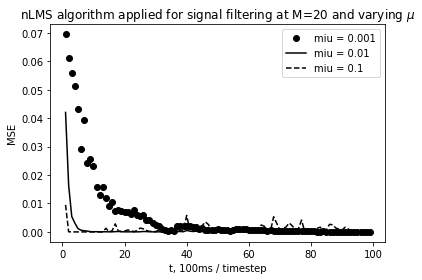

In [60]:
k = ['ko','k-','k--']
i = 0
for m0 in mses:
    plt.plot(m0[0][2][:100],k[i],label=f'miu = {m0[0][0]}')
    i+=1
plt.title("nLMS algorithm applied for signal filtering at M=20 and varying $\mu$")
plt.xlabel("t, 100ms / timestep")
plt.ylabel("MSE")
plt.legend()

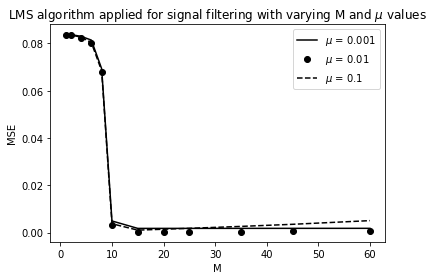

In [36]:
#x0 = [x[2] for x in mses[0]]
k = ['k','ko','k--']
i = 0
for m0 in mses:
    plt.plot([x[1] for x in m0],[x[2] for x in m0],k[i],label=f'$\mu$ = {m0[2][0]}')
    i+=1
plt.title("LMS algorithm applied for signal filtering with varying M and $\mu$ values")
plt.xlabel("M")
plt.ylabel("MSE")
plt.legend()

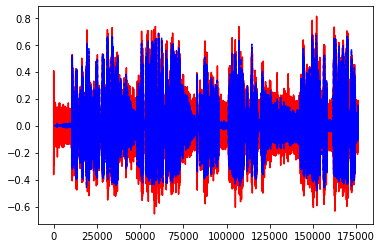

mse: 0.0037252437521056512


In [217]:
plt.plot(y,'r')
plt.plot(sn,'--b')
plt.show()
print(f"mse: {mse(sn,y)}")

In [196]:
from scipy.io.wavfile import write
write('y.wav',8000, y)
write('sn.wav',8000, sn)
write('dn.wav',8000, dn)
write('xa.wav',8000, xa)

In [28]:
dn = inputs['kabinosSig'].data # dn
xa = inputs['variklioSig'].data # xa
sn = inputs['pilotoSig'].data # sn
miu = 0.01
M = 20
mses = []
step = 800
af = AdaptiveFilter("adaptive filter",M,miu)
y = af.filter_signal(xa,dn)


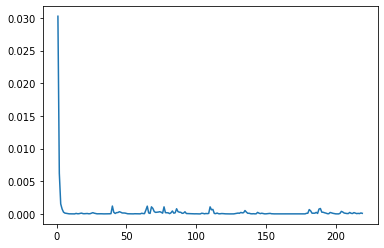

In [34]:
mses = mse_list(sn,y,step)
plt.plot(mses)

In [107]:
dn = inputs['kabinosSig'].data # dn
xa = inputs['variklioSig'].data # xa
sn = inputs['pilotoSig'].data # sn

af = AdaptiveFilter("adaptive filter",20,0.01)
y = af.filter_signal(xa,dn)
write('y_optimal.wav',8000, y)

In [109]:
#dn = inputs['kabinosSig'].data # dn
#xa = inputs['variklioSig'].data # xa
#sn = inputs['pilotoSig'].data # sn

af = AdaptiveFilter("adaptive filter",20,0.01)
y = af.filter_signal(xa,dn,True)
write('y_normalized.wav',8000, y)

In [275]:
af.xa.transpose().dot(af.xa)

0.40993023284983743

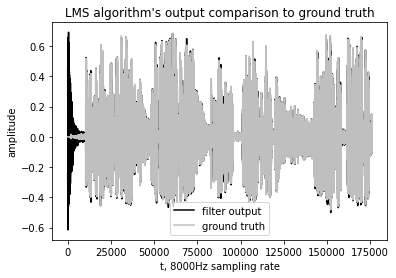

mse: 0.00039181537773123876


In [117]:
plt.plot(y,'k',label="filter output")
plt.plot(sn,'k',label='ground truth',c='0.75')
plt.title("LMS algorithm's output comparison to ground truth")
plt.ylabel("amplitude")
plt.xlabel("t, 8000Hz sampling rate")
plt.legend()
plt.show()

print(f"mse: {mse(sn,y)}")

In [91]:
class AdaptiveRMKFilter(Filter):
    def __init__(self,name,M,miu):
        super().__init__(name)
        self.M = M
        self.miu = miu
        self.w = np.zeros(M).transpose()
        self.xa = np.zeros(M).transpose()
        self.gamma = 0.01
        self.I = np.identity(M)
        self.P = self.I / self.gamma

        self.lambda0 = 1

    def norm(self,x):
        return np.matmul(x.transpose(),x)


    def adapt_step(self,x,d):
        self.xa = shift(self.xa,1)
        self.xa[0] = x
        xa = self.xa.reshape(self.M,1)
        P = self.P
        w = self.w.reshape(self.M,1)
        l = self.lambda0


        #print(f'l: {l}\nxa:\n{xa} \nP:\n{P}\nw:\n{w}')

        # RMS algorithm

        # np.matmul     returns matrix product of two given arrays
        # np.multiply   returns element-wise multiplication of two given arrays
        # np.dot        returns scalar or dot product of two given arrays

        v = np.matmul(P,xa)       
        u = np.matmul(P.transpose(),v)        
        #print(v)
        #print(v.shape)
        v = v.reshape(len(v),1)
        #print(v.shape)
        k = 1 / ( l + self.norm(v) + sqrt(l) * sqrt( l + self.norm(v) ) )
        
        xiv = np.matmul(w.transpose(),xa)
        siv = d - xiv    

        self.P = ( P - k * np.matmul(v,u.transpose())) / sqrt(l)    
        self.w = w + (siv*u)/(l + self.norm(v))
        #print(w.shape,xa.shape,v.shape,u.shape)
        #print("\nafter calculations\n")
        #print(f"\nv: {v} \nu: {u} \nk:{k} \nnew P: \n{self.P} \nxiv:\n{xiv}\nnew w:\n{self.w}")
        return siv

    def filter_signal(self,x,d):
        y = np.zeros(len(x))
        for i in range(len(x)):
            #print(f"\niteration: {i}")
            y[i] = self.adapt_step(x[i],d[i])
        return y

dn = inputs['kabinosSig'].data # dn
xa = inputs['variklioSig'].data # xa
sn = inputs['pilotoSig'].data # sn



af = AdaptiveRMKFilter("adaptive filter",20,0.01)
#y = af.filter_signal(xa[0:20],dn[0:20])
y = af.filter_signal(xa,dn)
#y = af.filter_signal(xa[:2],dn[:2])
#write('y_rmk.wav',8000, y)

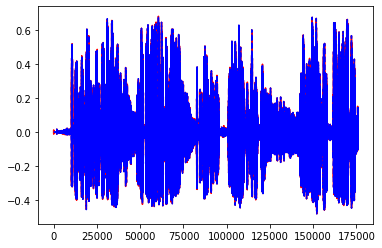

mse: 0.0008138484742562164


In [106]:
plt.plot(y[100:],'r')
plt.plot(sn[100:],'b--')
plt.show()

print(f"mse: {mse(sn,y)}")

In [243]:
write('y_rmk.wav',8000, y)

In [68]:
dn = inputs['kabinosSig'].data # dn
xa = inputs['variklioSig'].data # xa
sn = inputs['pilotoSig'].data # sn
mius = [0.95,0.96,0.97,0.98,0.99,1]
Ms = [2,4,6,8,10,15,20,30,40,60]
mses = []
step = 800
for miu in mius:
    m0 = []
    for M in Ms:
        #af = AdaptiveFilter("adaptive filter",M,miu)
        af = AdaptiveRMKFilter("adaptive filter",M,miu)
        y = af.filter_signal(xa,dn)
        #m0.append((miu,M,mse_list(sn,y,step)))
        m0.append((miu,M,mse(sn,y)))
        print(miu,M," done")
    mses.append(m0)

0.95 2  done
0.95 4  done
0.95 6  done
0.95 8  done
0.95 10  done
0.95 15  done
0.95 20  done
0.95 30  done
0.95 40  done
0.95 60  done
0.96 2  done
0.96 4  done
0.96 6  done
0.96 8  done
0.96 10  done
0.96 15  done
0.96 20  done
0.96 30  done
0.96 40  done
0.96 60  done
0.97 2  done
0.97 4  done
0.97 6  done
0.97 8  done
0.97 10  done
0.97 15  done
0.97 20  done
0.97 30  done
0.97 40  done
0.97 60  done
0.98 2  done
0.98 4  done
0.98 6  done
0.98 8  done
0.98 10  done
0.98 15  done
0.98 20  done
0.98 30  done
0.98 40  done
0.98 60  done
0.99 2  done
0.99 4  done
0.99 6  done
0.99 8  done
0.99 10  done
0.99 15  done
0.99 20  done
0.99 30  done
0.99 40  done
0.99 60  done
1 2  done
1 4  done
1 6  done
1 8  done
1 10  done
1 15  done
1 20  done
1 30  done
1 40  done
1 60  done


In [119]:
k = ['k','ko','k--','r','ro','r--']
i = 0
for m0 in mses:
    plt.plot([x[1] for x in m0],[x[2] for x in m0],k[i],label=f'$\lambda$ = {m0[2][0]}')
    i+=1
plt.title("RMS algorithm applied for signal filtering with varying M and $\lambda$ values, $\gamma$=0.01")
plt.xlabel("M")
plt.ylabel("MSE")
plt.legend()

IndexError: list index out of range

In [90]:
dn = inputs['kabinosSig'].data # dn
xa = inputs['variklioSig'].data # xa
sn = inputs['pilotoSig'].data # sn
mius = [0.01]
Ms = [20]
mses = []
step = 800
for miu in mius:
    m0 = []
    for M in Ms:
        #af = AdaptiveFilter("adaptive filter",M,miu)
        af = AdaptiveRMKFilter("adaptive filter",M,miu)
        y = af.filter_signal(xa,dn)
        #m0.append((miu,M,mse_list(sn,y,step)))
        m0.append((miu,M,mse(sn,y)))
        print(miu,M," done")
    mses.append(m0)

0.01 20  done


In [118]:
k = ['k','k3','k--','k.','k^']
i = 0
for m0 in mses:
    plt.plot(m0[0][2][:100],k[i],label=f'miu = {m0[0][0]}')
    i+=1
plt.title("RMS algorithm applied for signal filtering at M=20, $\lambda$=1 and varying $\gamma$")
plt.xlabel("t, 100ms / timestep")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()

IndexError: invalid index to scalar variable.